In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import root_mean_squared_error
import pickle
from prepare_data import PrepareData

In [112]:
df = PrepareData.df
train_data = PrepareData.train_data()
test_data = PrepareData.test_data()

# EDA

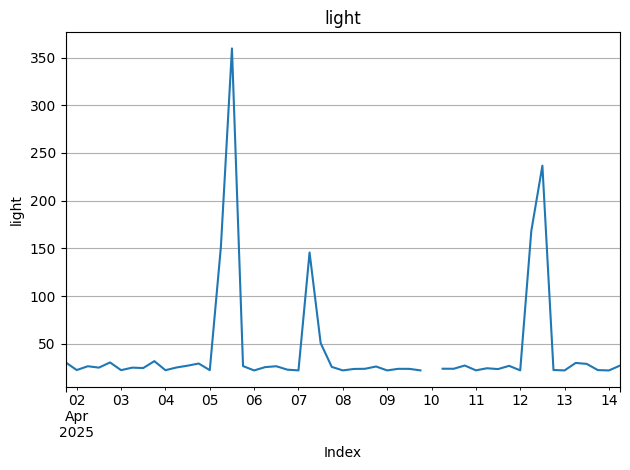

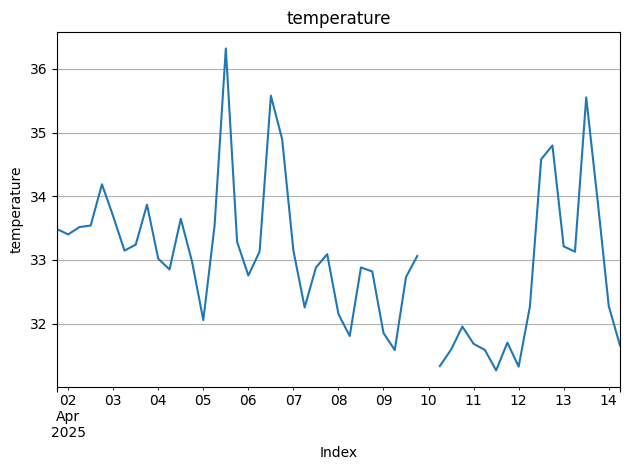

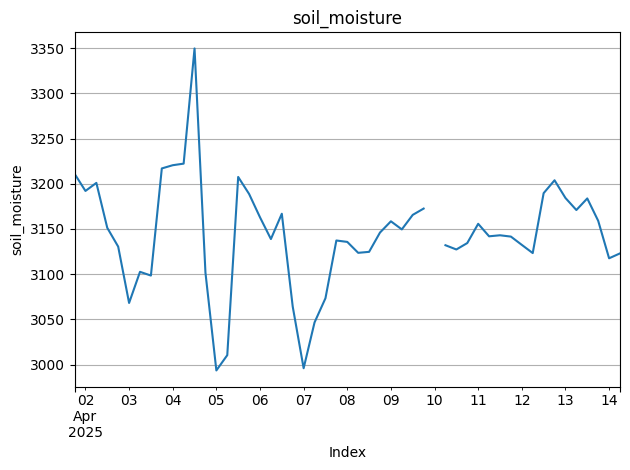

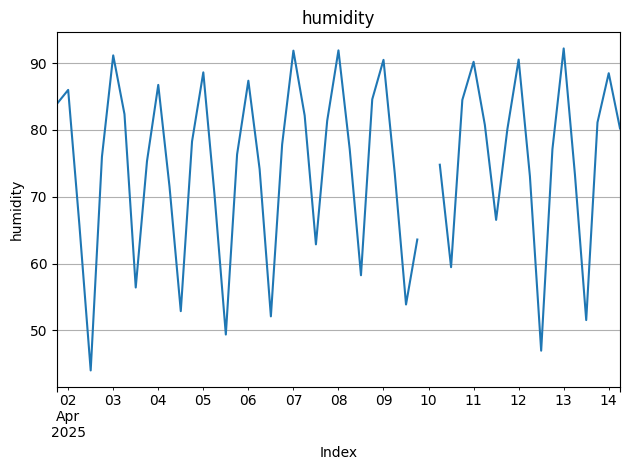

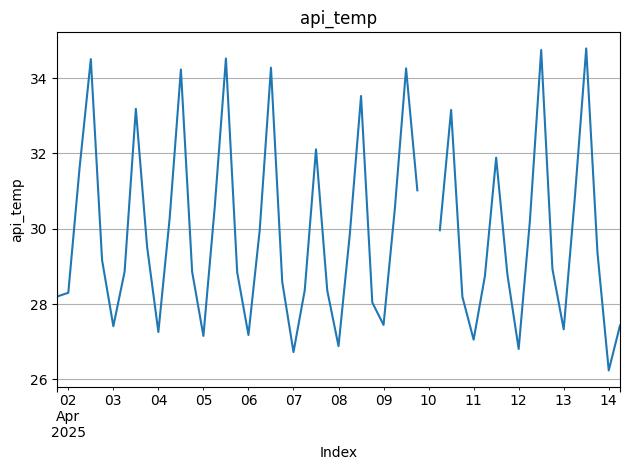

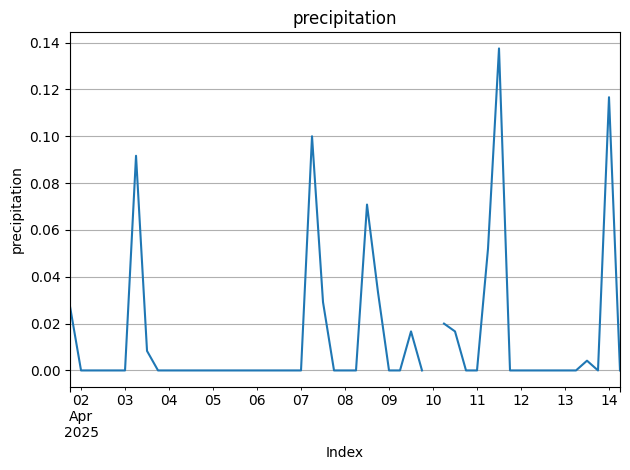

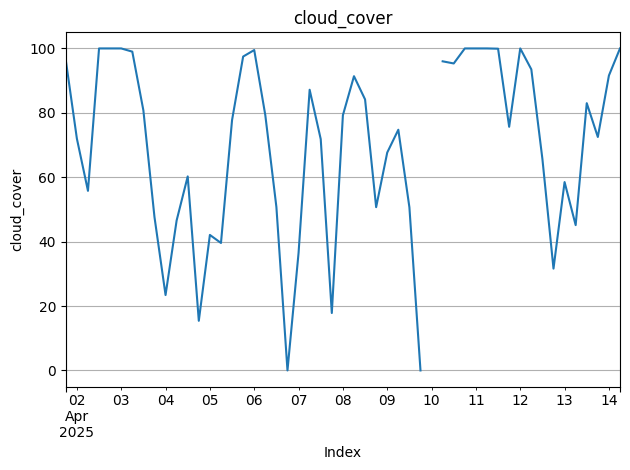

In [113]:
for column in df.columns:
    if column == "id":
        continue
    plt.figure()  # Create a new figure for each plot
    df[column].plot()
    plt.title(column)
    plt.xlabel("Index")  # or "Date" if it's time series
    plt.ylabel(column)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

<Axes: >

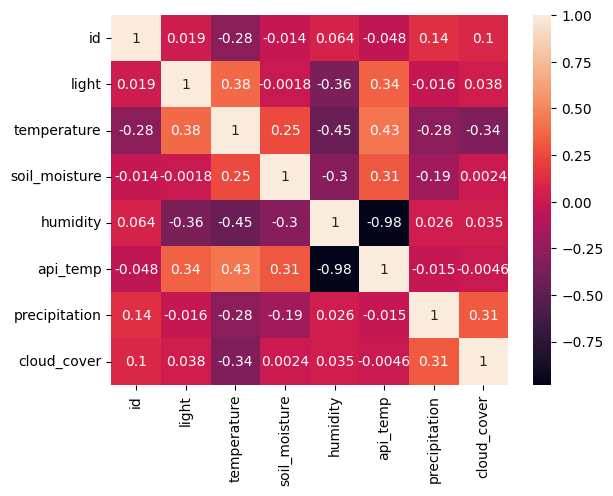

In [114]:
sns.heatmap(df.corr(),annot=True)

In [115]:
df["soil_moisture"].diff().dropna()

ts
2025-04-02 00:00:00    -19.045455
2025-04-02 06:00:00      8.916667
2025-04-02 12:00:00    -49.729167
2025-04-02 18:00:00    -20.770833
2025-04-03 00:00:00    -62.333333
2025-04-03 06:00:00     34.437500
2025-04-03 12:00:00     -4.125000
2025-04-03 18:00:00    118.500000
2025-04-04 00:00:00      3.562500
2025-04-04 06:00:00      1.750000
2025-04-04 12:00:00    127.437500
2025-04-04 18:00:00   -248.062500
2025-04-05 00:00:00   -108.145833
2025-04-05 06:00:00     16.916667
2025-04-05 12:00:00    197.125000
2025-04-05 18:00:00    -18.805254
2025-04-06 00:00:00    -25.840580
2025-04-06 06:00:00    -24.037879
2025-04-06 12:00:00     27.990260
2025-04-06 18:00:00   -102.744048
2025-04-07 00:00:00    -68.166667
2025-04-07 06:00:00     50.680417
2025-04-07 12:00:00     26.736250
2025-04-07 18:00:00     63.895833
2025-04-08 00:00:00     -1.562500
2025-04-08 06:00:00    -12.083333
2025-04-08 12:00:00      1.083333
2025-04-08 18:00:00     21.354167
2025-04-09 00:00:00     12.437500
2025-04-09 

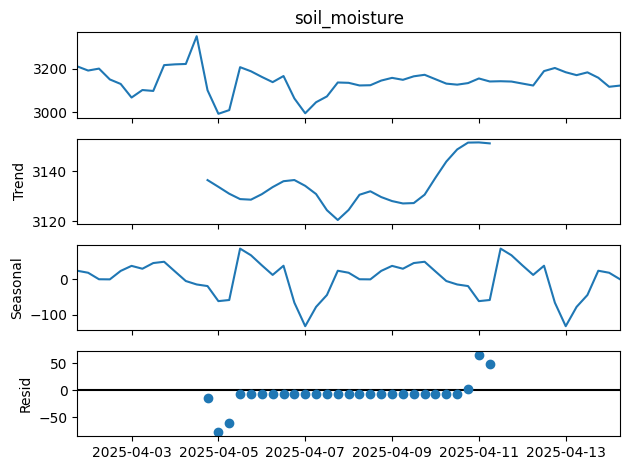

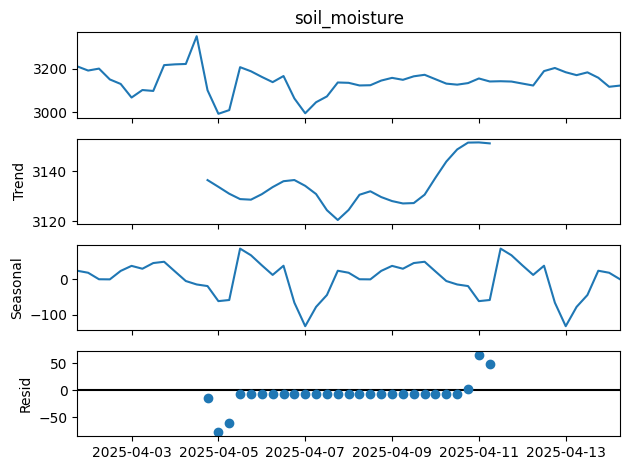

In [116]:
seasonal_decompose(df["soil_moisture"].interpolate(), model="additive").plot()


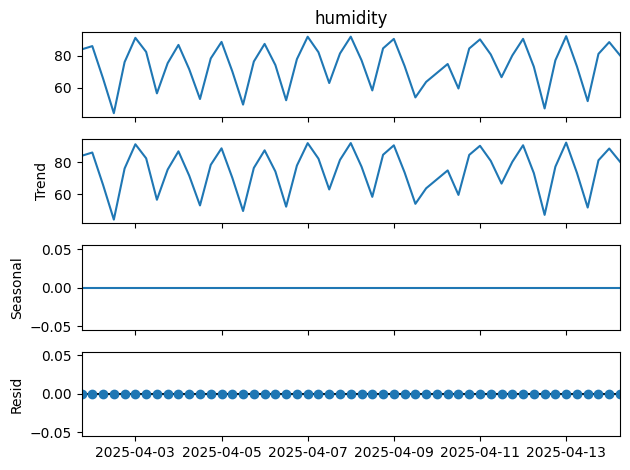

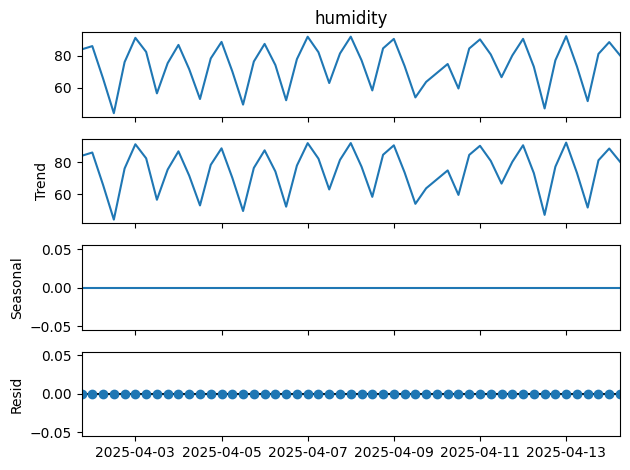

In [117]:
seasonal_decompose(df["humidity"].interpolate(), model="additive", period=1).plot()

## Find D parameter

We'll use adfuller test.

In [118]:
data = df["soil_moisture"].dropna()
diff = 0
while True:
    result = adfuller(data)
    if result[1] < 0.05:
        print(f"d={diff}")
        print('ADF Statistic:', result[0])
        print('p-value:', result[1])
        for key, value in result[4].items():
            print('Critial Values:')
            print(f'   {key}, {value}')
        break
    data = data.diff().dropna()
    diff+=1

d=1
ADF Statistic: -6.213627252282194
p-value: 5.431988647417011e-08
Critial Values:
   1%, -3.5925042342183704
Critial Values:
   5%, -2.931549768951162
Critial Values:
   10%, -2.60406594375338


Therefore, d=1.

## Find P parameter

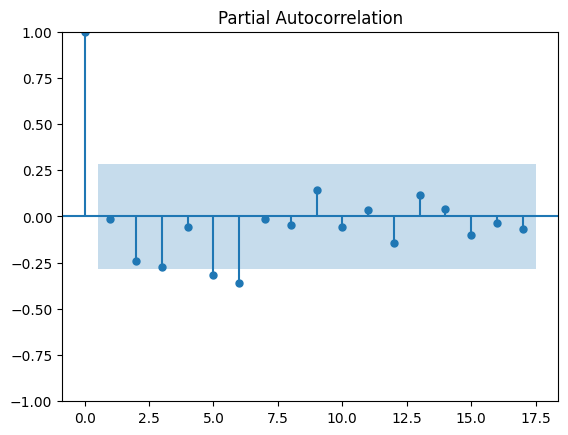

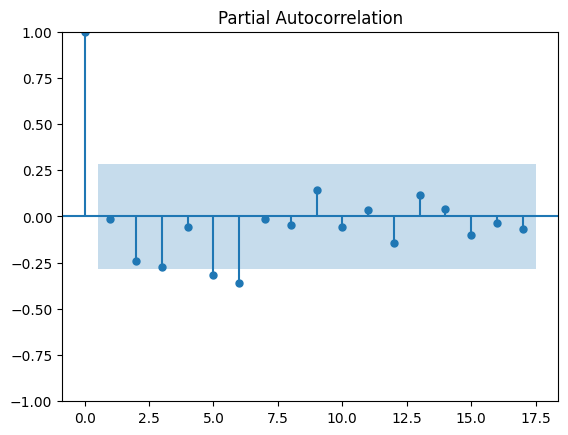

In [119]:
plot_pacf(df["soil_moisture"].diff().dropna())


There are 1 exceptionally high bars, therefore, p=1

## Find Q parameter

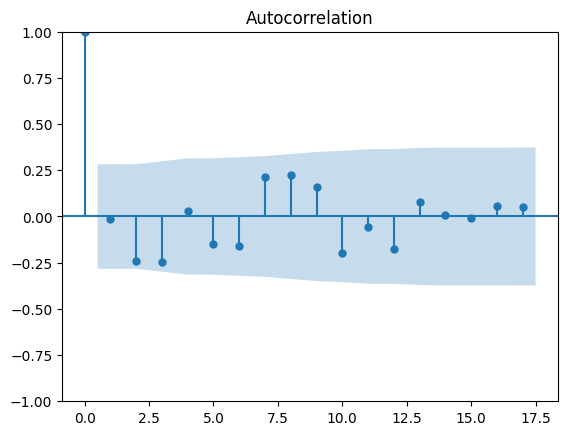

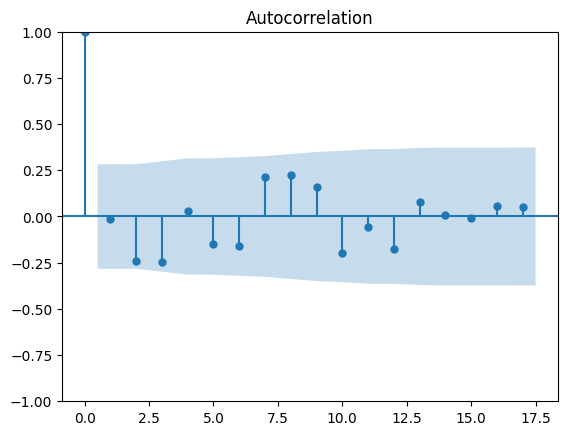

In [120]:
plot_acf(df["soil_moisture"].diff().dropna())

There are 1 exceptionally high bars, therefore, q=1

# Pre-Processing

In [121]:
train_data.head()

,id,light,temperature,soil_moisture,humidity,api_temp,precipitation,cloud_cover
ts,,,,,,,,
2025-04-01 18:00:00,6.0,30.485055,33.485800,3211.045455,83.909091,28.200000,0.027273,96.363636
2025-04-02 00:00:00,13.0,22.453833,33.401067,3192.000000,86.000000,28.300000,0.000000,72.000000
2025-04-02 06:00:00,23.5,26.436983,33.516494,3200.916667,65.722222,31.611111,0.000000,55.777778
2025-04-02 12:00:00,44.5,24.979783,33.541017,3151.187500,44.000000,34.504167,0.000000,100.000000
2025-04-02 18:00:00,68.5,30.427021,34.188162,3130.416667,76.000000,29.166667,0.000000,100.000000


In [122]:
test_data.head()

,id,light,temperature,soil_moisture,humidity,api_temp,precipitation,cloud_cover
ts,,,,,,,,
2025-04-09 00:00:00,662.5,22.044396,31.854167,3158.416667,90.500,27.445833,0.000000,67.666667
2025-04-09 06:00:00,686.5,23.729654,31.586587,3149.458333,73.500,30.525000,0.000000,74.750000
2025-04-09 12:00:00,710.5,23.680588,32.733071,3165.520833,53.875,34.258333,0.016667,50.666667
2025-04-09 18:00:00,725.0,22.092880,33.062520,3172.500000,63.600,31.020000,0.000000,0.000000
2025-04-10 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [123]:
train_data[["soil_moisture"]]

,soil_moisture
ts,
2025-04-01 18:00:00,3211.045455
2025-04-02 00:00:00,3192.000000
2025-04-02 06:00:00,3200.916667
2025-04-02 12:00:00,3151.187500
2025-04-02 18:00:00,3130.416667
2025-04-03 00:00:00,3068.083333
2025-04-03 06:00:00,3102.520833
2025-04-03 12:00:00,3098.395833
2025-04-03 18:00:00,3216.895833


In [124]:
test_data['soil_moisture'].count()

8

In [125]:
test_data[['light', 'precipitation']]

,light,precipitation
ts,,
2025-04-09 00:00:00,22.044396,0.000000
2025-04-09 06:00:00,23.729654,0.000000
2025-04-09 12:00:00,23.680588,0.016667
2025-04-09 18:00:00,22.092880,0.000000
2025-04-10 00:00:00,NaN,NaN
2025-04-10 06:00:00,23.824460,0.020000
2025-04-10 12:00:00,23.791867,0.016667
2025-04-10 18:00:00,27.169396,0.000000
2025-04-11 00:00:00,22.121229,0.000000


# Train the model

Import the model to predict the exog values

In [126]:
# Import exog data predicting models 
with open('../exports/api_temp_sarima.pkl', 'rb') as file:
    api_temp_model = pickle.load(file)

with open('../exports/humidity_sarima.pkl', 'rb') as file:
    humidity_model = pickle.load(file)

with open('../exports/temperature_sarima.pkl', 'rb') as file:
    temperature_model = pickle.load(file)
    
with open('../exports/light_sarima.pkl', 'rb') as file:
    light_model = pickle.load(file)
    
with open('../exports/precipitation_sarima.pkl', 'rb') as file:
    precipitation_model = pickle.load(file)

In [127]:
light_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             light   No. Observations:                   26
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 3)   Log Likelihood                -148.988
Date:                           Tue, 29 Apr 2025   AIC                            307.976
Time:                                   21:22:04   BIC                            314.266
Sample:                               04-01-2025   HQIC                           309.787
                                    - 04-08-2025                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1582      1.443      0.110      0.913      -2.670       2.986
ma.L1          0.2515      1.620      0.155      0.877      -2.924       3.428
ar.S.L3        0.9998      0.039     25.762      0.000       0.924       1.076
ma.S.L3       -0.9927      0.712     -1.395      0.163      -2.388       0.402
sigma2      5100.2459      0.000   3.66e+07      0.000    5100.246    5100.246
===================================================================================
Ljung-Box (L1) (Q):                   0.36   Jarque-Bera (JB):                66.86
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               8.39   Skew:                             2.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.35e+25. Standard errors may be unstable.
"""

In [128]:
# Predicting the data
forecast_steps = len(test_data)

# Get forecasts and rename columns immediately
exog_predictions = (
    precipitation_model.get_forecast(steps=forecast_steps)
    .predicted_mean
    .rename('precipitation')
    .to_frame()
)

light_predictions = (
    light_model.get_forecast(steps=forecast_steps)
    .predicted_mean
    .rename('light')
    .to_frame()
)

# temperature_predictions = (
#     temperature_model.get_forecast(steps=forecast_steps)
#     .predicted_mean
#     .rename('temperature')
#     .to_frame()
# )

# Combine exogenous variables
exog_predictions = pd.concat(
    [exog_predictions, light_predictions], 
    axis=1
)

# If using temperature:
# exog_predictions = pd.concat(
#     [exog_predictions, temperature_predictions], 
#     axis=1
# )

print(exog_predictions.columns)
print(test_data[['light', 'precipitation']])
exog_predictions.head()

Index(['precipitation', 'light'], dtype='object')
                         light  precipitation
ts                                           
2025-04-09 00:00:00  22.044396       0.000000
2025-04-09 06:00:00  23.729654       0.000000
2025-04-09 12:00:00  23.680588       0.016667
2025-04-09 18:00:00  22.092880       0.000000
2025-04-10 00:00:00        NaN            NaN
2025-04-10 06:00:00  23.824460       0.020000
2025-04-10 12:00:00  23.791867       0.016667
2025-04-10 18:00:00  27.169396       0.000000
2025-04-11 00:00:00  22.121229       0.000000


,precipitation,light
2025-04-08 06:00:00,0.036734,23.784553
2025-04-08 12:00:00,0.010834,33.899941
2025-04-08 18:00:00,0.008534,20.639280
2025-04-09 00:00:00,0.004791,22.474972
2025-04-09 06:00:00,0.037796,33.686628


In [129]:
print("Training exog stats:")
print(train_data[['precipitation', 'light']].describe())

print("\nPrediction exog stats:")
print(exog_predictions.describe())

Training exog stats:
       precipitation       light
count      26.000000   26.000000
mean        0.009863   48.652829
std         0.026486   71.757186
min         0.000000   22.052842
25%         0.000000   22.546738
50%         0.000000   25.637452
75%         0.000000   30.141403
max         0.100000  359.524546

Prediction exog stats:
       precipitation      light
count       9.000000   9.000000
mean        0.018322  25.758879
std         0.014781   6.091149
min         0.004791  20.598045
25%         0.008534  20.639280
50%         0.010834  22.474972
75%         0.036734  33.678893
max         0.038859  33.899941


## Pre-Processing

In [130]:
train_data["soil_moisture"] = train_data["soil_moisture"].ffill()
test_data["soil_moisture"] = test_data["soil_moisture"].ffill()

/tmp/ipykernel_88636/1675882355.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data["soil_moisture"] = train_data["soil_moisture"].ffill()
/tmp/ipykernel_88636/1675882355.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["soil_moisture"] = test_data["soil_moisture"].ffill()


## Actual Prediction

In [131]:
train_data['soil_moisture']

ts
2025-04-01 18:00:00    3211.045455
2025-04-02 00:00:00    3192.000000
2025-04-02 06:00:00    3200.916667
2025-04-02 12:00:00    3151.187500
2025-04-02 18:00:00    3130.416667
2025-04-03 00:00:00    3068.083333
2025-04-03 06:00:00    3102.520833
2025-04-03 12:00:00    3098.395833
2025-04-03 18:00:00    3216.895833
2025-04-04 00:00:00    3220.458333
2025-04-04 06:00:00    3222.208333
2025-04-04 12:00:00    3349.645833
2025-04-04 18:00:00    3101.583333
2025-04-05 00:00:00    2993.437500
2025-04-05 06:00:00    3010.354167
2025-04-05 12:00:00    3207.479167
2025-04-05 18:00:00    3188.673913
2025-04-06 00:00:00    3162.833333
2025-04-06 06:00:00    3138.795455
2025-04-06 12:00:00    3166.785714
2025-04-06 18:00:00    3064.041667
2025-04-07 00:00:00    2995.875000
2025-04-07 06:00:00    3046.555417
2025-04-07 12:00:00    3073.291667
2025-04-07 18:00:00    3137.187500
2025-04-08 00:00:00    3135.625000
Freq: 6h, Name: soil_moisture, dtype: float64

In [132]:
model = SARIMAX(
    endog=train_data['soil_moisture'],
    exog=train_data[['precipitation', 'light']],
    order=(0, 1, 0)
)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          soil_moisture   No. Observations:                   26
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -145.109
Date:                Tue, 29 Apr 2025   AIC                            296.218
Time:                        21:22:05   BIC                            299.875
Sample:                    04-01-2025   HQIC                           297.232
                         - 04-08-2025                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
precipitation   -41.4596   1111.191     -0.037      0.970   -2219.353    2136.434
light             0.2800      0.171      1.642      0.101      -0.054       0.614
sigma2         6443.5819   1346.465      4.786      0.000    3804.559    9082.605
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                 5.31
Prob(Q):                              0.77   Prob(JB):                         0.07
Heteroskedasticity (H):               1.11   Skew:                            -0.75
Prob(H) (two-sided):                  0.89   Kurtosis:                         4.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [133]:
steps = int(test_data['soil_moisture'].count())
prediction = results.get_forecast(steps=steps , exog=exog_predictions[['precipitation', 'light']].iloc[:steps]).predicted_mean
prediction.columns = ['predicted']
prediction

2025-04-08 06:00:00    3134.585514
2025-04-08 12:00:00    3138.492063
2025-04-08 18:00:00    3134.873824
2025-04-09 00:00:00    3135.543116
2025-04-09 06:00:00    3137.314497
2025-04-09 12:00:00    3134.724101
2025-04-09 18:00:00    3135.341115
2025-04-10 00:00:00    3138.636675
2025-04-10 06:00:00    3133.605051
Freq: 6h, Name: predicted_mean, dtype: float64

In [134]:
test_data.index

DatetimeIndex(['2025-04-09 00:00:00', '2025-04-09 06:00:00',
               '2025-04-09 12:00:00', '2025-04-09 18:00:00',
               '2025-04-10 00:00:00', '2025-04-10 06:00:00',
               '2025-04-10 12:00:00', '2025-04-10 18:00:00',
               '2025-04-11 00:00:00'],
              dtype='datetime64[ns]', name='ts', freq='6h')

In [135]:
prediction

2025-04-08 06:00:00    3134.585514
2025-04-08 12:00:00    3138.492063
2025-04-08 18:00:00    3134.873824
2025-04-09 00:00:00    3135.543116
2025-04-09 06:00:00    3137.314497
2025-04-09 12:00:00    3134.724101
2025-04-09 18:00:00    3135.341115
2025-04-10 00:00:00    3138.636675
2025-04-10 06:00:00    3133.605051
Freq: 6h, Name: predicted_mean, dtype: float64

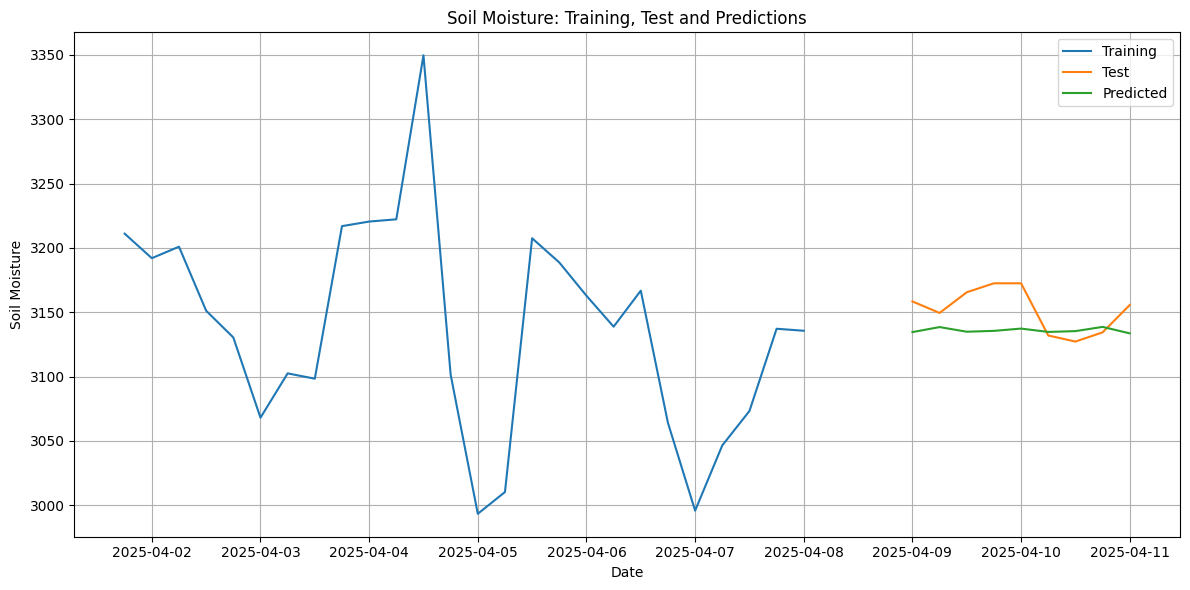

RMSE :  23.114571604922578


In [136]:
plt.figure(figsize=(12, 6))
# Ensure datetime index and proper plotting
plt.plot(train_data.index, train_data["soil_moisture"], label="Training")
plt.plot(test_data.index, test_data["soil_moisture"], label="Test")
plt.plot(test_data.index, prediction, label="Predicted")  # use the same x-axis as test

plt.legend()
plt.xlabel("Date")
plt.ylabel("Soil Moisture")
plt.title("Soil Moisture: Training, Test and Predictions")
plt.grid(True)
plt.tight_layout()
plt.show()

print("RMSE : ", root_mean_squared_error(test_data['soil_moisture'], prediction))


## Exporting the trained model with Pickle for external uses.

**Warning** : Do not unpickle untrusted model because it might execute a malicious code hidden in the model file.

In [137]:
with open('../exports/plant_water.pkl', 'wb') as file:
    pickle.dump(results, file)